In [1]:
import logging
from importlib import reload

import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
from himalaya.backend import set_backend
from matplotlib import axes

from simulation import generate_dataset

set_backend("cupy", on_error="warn")

# disable warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
def generic_errorbar_plot(means, variances, labels, horizontal_positions, title, suptitle, ylabel, xlabel,  n_samples_train, n_samples_test,ax: axes.Axes = None, fig=None):
    """Generic plot function for shared parameters between vp_errorbar and rm_errorbar."""

    if ax is None or fig is None:
        fig, ax = plt.subplots()

    yerr =  [np.sqrt(var) / np.sqrt(n_samples_test) for var in variances]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

    # Create bar plot
    bars = ax.bar(range(len(means)), means, color=colors[:len(means)], yerr=yerr, capsize=5, ecolor="black")
    ax.bar_label(bars, fmt='{:,.2f}', label_type='center')
    ax.set_xticks(range(len(means)), labels=labels)

    # Function to plot horizontal lines
    def plot_horizontal_line(start, end, y_value, label, color):
        ax.plot([start, end], [y_value, y_value], linestyle='--', label=label, color=color)

    # Plot horizontal lines
    for i, (y_value, label, start, end) in enumerate(horizontal_positions):
        plot_horizontal_line(start, end, y_value, label, colors[i % len(colors)])

    ax.legend()

    ylims = ax.get_ylim()
    ax.set_ylim(ylims[0], 1.01)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    fig.suptitle(suptitle)
    ax.set_title(title)
    return ax, fig

In [4]:
feature_space_dimensions = [
    100,  # shared
    100,  # unique 0
    100,  # unique 1
]
scalars = [
1/3 , 1/3 , 1/3
]
n_targets = 1000
n_samples_train = 10000
n_samples_test = 1000
noise_scalar = 0.1

cv = 20
alphas=np.logspace(-4, 4, 10)

In [5]:
(Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(feature_space_dimensions, scalars, n_targets, n_samples_train,
                                                        n_samples_test, noise_scalar)

# Variance Partitioning

In [6]:
def vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars,
                n_targets, n_samples_train, n_samples_test, noise_scalar, ax: axes.Axes = None, fig=None):
    # Precompute means and variances
    scores = [score_0, score_1, joint_score, shared, x0_unique, x1_unique]
    means = [s.mean() for s in scores]
    variances = [s.var() for s in scores]

    bar_names = [r"$X_0$", r"$X_1$", r"$X_0 \cup X_1$", r"$X_0 \cap X_1$", r"$X_0 \setminus X_1$", r"$X_1 \setminus X_0$"]

    # Horizontal line positions
    horizontal_positions = [
        (scalars[0] + scalars[1], r"$a_S + a_{U_0}$", -0.5, 0.5),
        (scalars[0] + scalars[2], r"$a_S + a_{U_1}$", 0.5, 1.5),
        (sum(scalars), r"$a_S + a_{U_0} + a_{U_1}$", 1.5, 2.5),
        (scalars[0], r"$a_S$", 2.5, 3.5),
        (scalars[1], r"$a_{U_0}$", 3.5, 4.5),
        (scalars[2], r"$a_{U_1}$", 4.5, 5.5)
    ]

    # Call the generic function
    generic_errorbar_plot(
        means=means,
        variances=variances,
        labels=bar_names,
        horizontal_positions=horizontal_positions,
        title=fr"$a_S$: {scalars[0]:.2f}, $a_{{U_0}}$: {scalars[1]:.2f}, $a_{{U_1}}$: {scalars[2]:.2f}, $|S|$: {feature_space_dimensions[0]}, $|U_0|$: {feature_space_dimensions[1]}, $|U_1|$: {feature_space_dimensions[2]}, $a_E$: {noise_scalar}",
        suptitle="Variance partitioning",
        ylabel=r"Average Variance Explained ($r^2$)",
        xlabel="Feature space",
        n_samples_test=n_samples_test,
        n_samples_train=n_samples_train,
        ax=ax,
        fig=fig
    )

In [7]:
from variance_partitioning import variance_partitioning

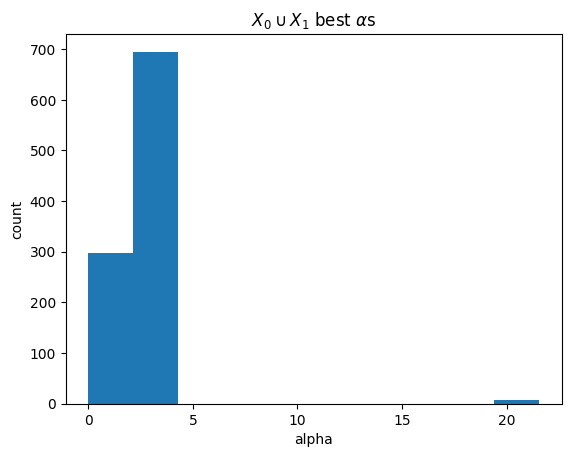

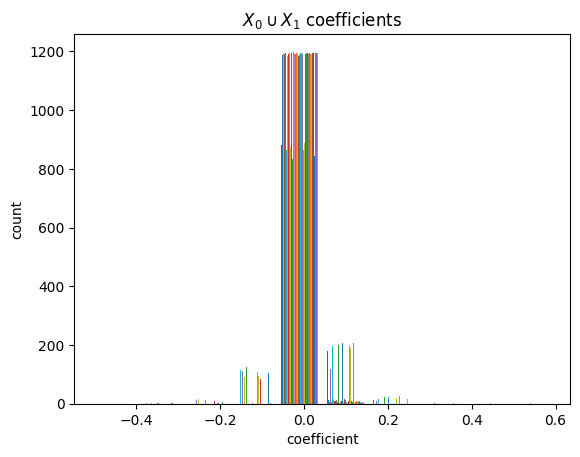

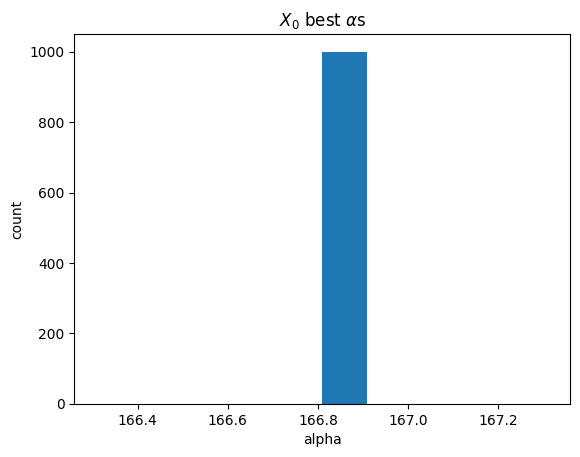

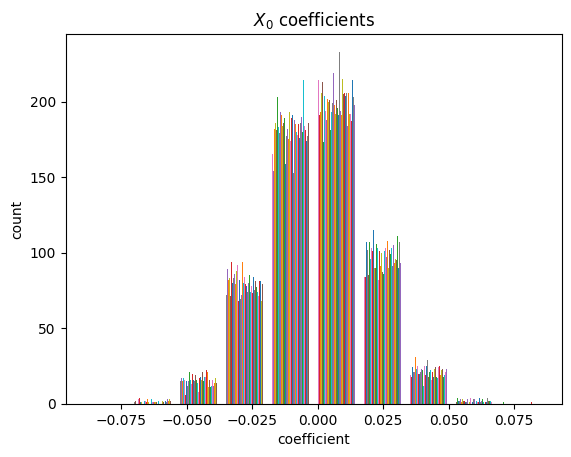

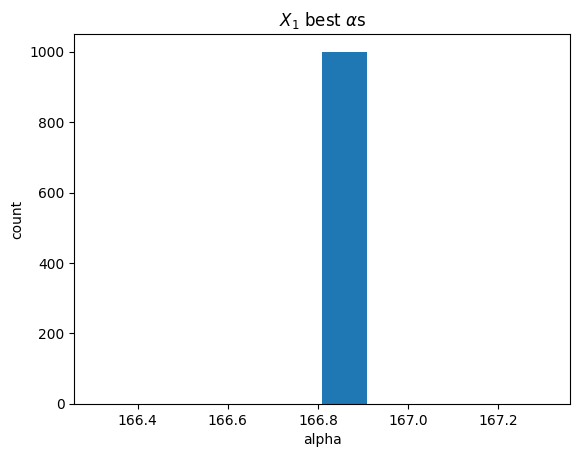

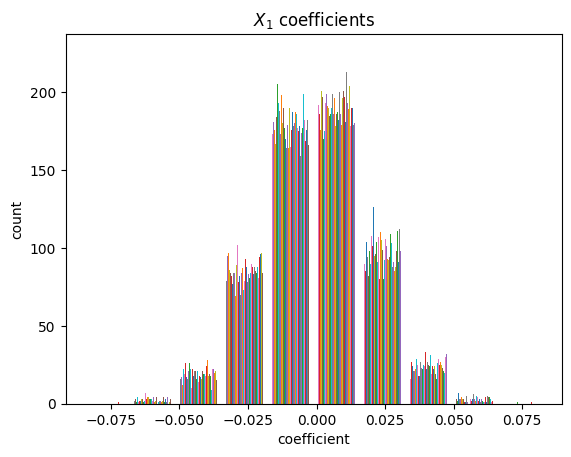

In [8]:
(score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test, Y_train,
                                                                                      Y_test, cv=cv, alphas=alphas, logger=logger)

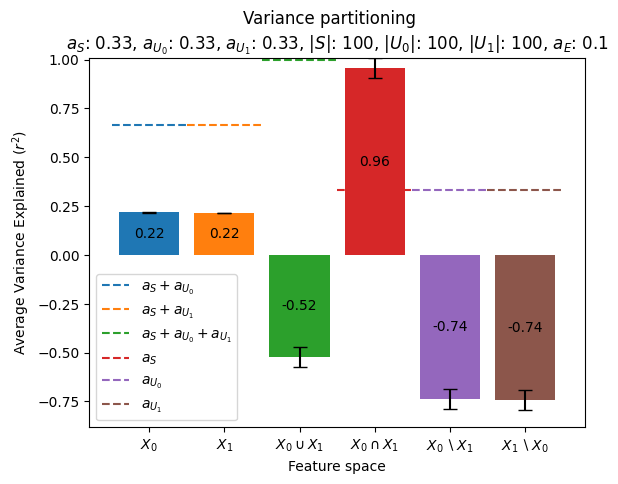

In [9]:
vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars, n_targets,
            n_samples_train, n_samples_test, noise_scalar)

## Try using ols for all models

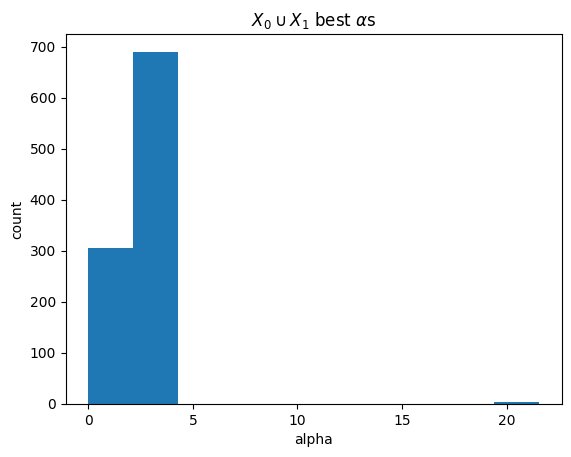

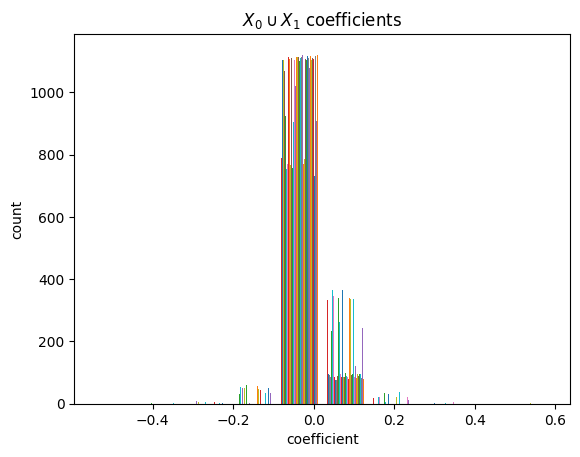

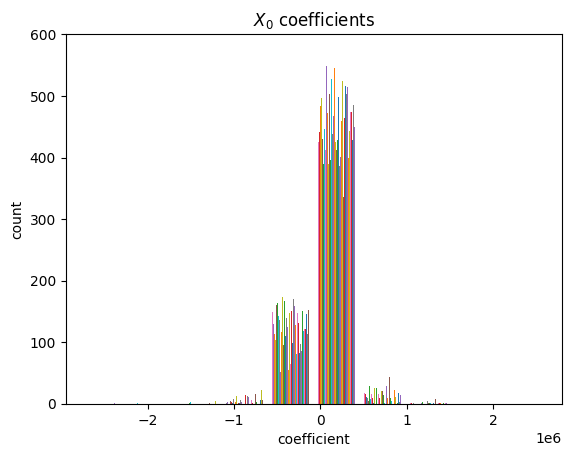

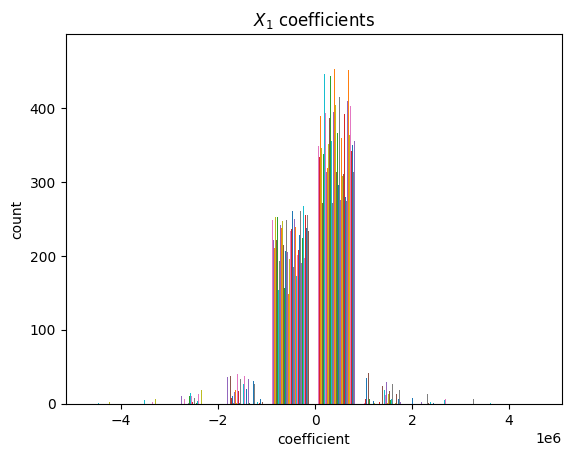

In [10]:
(score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test, Y_train,
                                                                                      Y_test, cv=cv, alphas=alphas, logger=logger, use_ols=True)

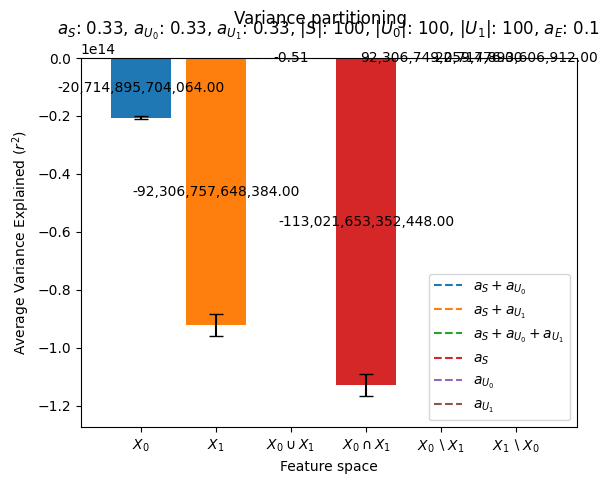

In [11]:
vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars, n_targets,
            n_samples_train, n_samples_test, noise_scalar)

# Residual Method

In [12]:
from residual import residual_method

In [13]:
def rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1,
                feature_space_dimensions, scalars,
                n_targets, n_samples_train, n_samples_test, noise_scalar, ax: axes.Axes = None, fig=None):
    if ax is None or fig is None:
        fig, ax = plt.subplots()

    # Precompute means and variances
    scores = [full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1]
    means = [s.mean() for s in scores]
    variances = [s.var() for s in scores]

    bar_names = [r"$X_0$", r"$X_1$", r"$f(X_1) \approx X_0$", r"$g(X_0) \approx X_1$", r"$X_0 \setminus X_1$",
                 r"$X_1 \setminus X_0$"]

    horizontal_positions = [
        (scalars[0] + scalars[1], r"$a_S + a_{U_0}$", -0.5, 0.5),
        (scalars[0] + scalars[2], r"$a_S + a_{U_1}$", 0.5, 1.5),
        (feature_space_dimensions[0] / (feature_space_dimensions[0] + feature_space_dimensions[1]),
         r"$\frac{|S|}{|U_0|+|S|}$", 1.5, 2.5),
        (feature_space_dimensions[0] / (feature_space_dimensions[0] + feature_space_dimensions[2]),
         r"$\frac{|S|}{|U_1|+|S|}$", 2.5, 3.5),
        (scalars[1], r"$a_{U_0}$", 3.5, 4.5),
        (scalars[2], r"$a_{U_1}$", 4.5, 5.5)
    ]

    # Call the generic_errorbar function with the required data and parameters
    generic_errorbar_plot(
        means=means,
        variances=variances,
        labels=bar_names,
        horizontal_positions=horizontal_positions,
        title=fr"{n_targets} targets, $a_S$: {scalars[0]:.2f}, $|S|$: {feature_space_dimensions[0]}, $a_{{U_0}}$: {scalars[1]:.2f}, $|U_0|$: {feature_space_dimensions[1]}, $a_{{U_1}}$: {scalars[2]:.2f}, $|U_1|$: {feature_space_dimensions[2]}, $a_E$: {noise_scalar}",
        suptitle="Residual Method",
        ylabel=r"Average Variance Explained ($r^2$)",
        xlabel="Feature space/Model",
        n_samples_test=n_samples_test,
        n_samples_train=n_samples_train,
        ax=ax,
        fig=fig
    )

In [14]:
full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1 = residual_method(
    Xs_train, Xs_test, Y_train, Y_test, use_ols=True, return_full_variance=True, cv=cv, score_func=himalaya.scoring.r2_score
)

04:55:15 DEBUG:linear model coefficients: [[ 3.26766253e-01  2.26822495e-03 -2.59987023e-02 ... -1.09112577e-08
   4.04406597e-09  8.22259949e-09]
 [ 2.26819562e-03  3.32072854e-01 -4.45721522e-02 ...  2.61934474e-10
  -2.33558239e-09 -1.01281330e-08]
 [-2.59986892e-02 -4.45720889e-02  3.43900919e-01 ... -4.42378223e-09
   1.22818165e-08 -8.38190317e-09]
 ...
 [ 6.13605222e-10 -1.95667260e-10 -3.18016324e-09 ... -7.04930059e-10
   1.38203093e-09 -4.09562206e-09]
 [ 5.42546841e-10  4.22670010e-10  2.14857310e-09 ... -1.36274741e-11
   1.55436197e-09 -1.66962355e-09]
 [ 8.23463020e-10 -1.75728365e-09 -1.09829545e-09 ...  7.23268223e-10
   2.17852292e-09 -8.32659053e-10]]
04:55:19 DEBUG:linear model coefficients: [[ 3.2676628e-01  2.2681952e-03 -2.5998646e-02 ... -2.2151259e-09
   1.0539787e-09  2.5269342e-09]
 [ 2.2681803e-03  3.3207288e-01 -4.4572163e-02 ... -1.6530976e-08
   1.7011189e-08  1.3096724e-10]
 [-2.5998639e-02 -4.4572130e-02  3.4390122e-01 ...  3.2036041e-08
   1.0477379e-09

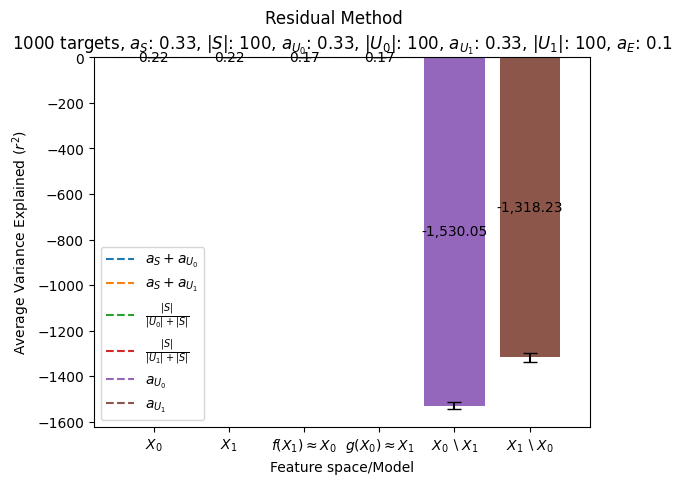

In [15]:
rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1,
            feature_space_dimensions, scalars,
            n_targets, n_samples_train, n_samples_test, noise_scalar)

# Dimensions

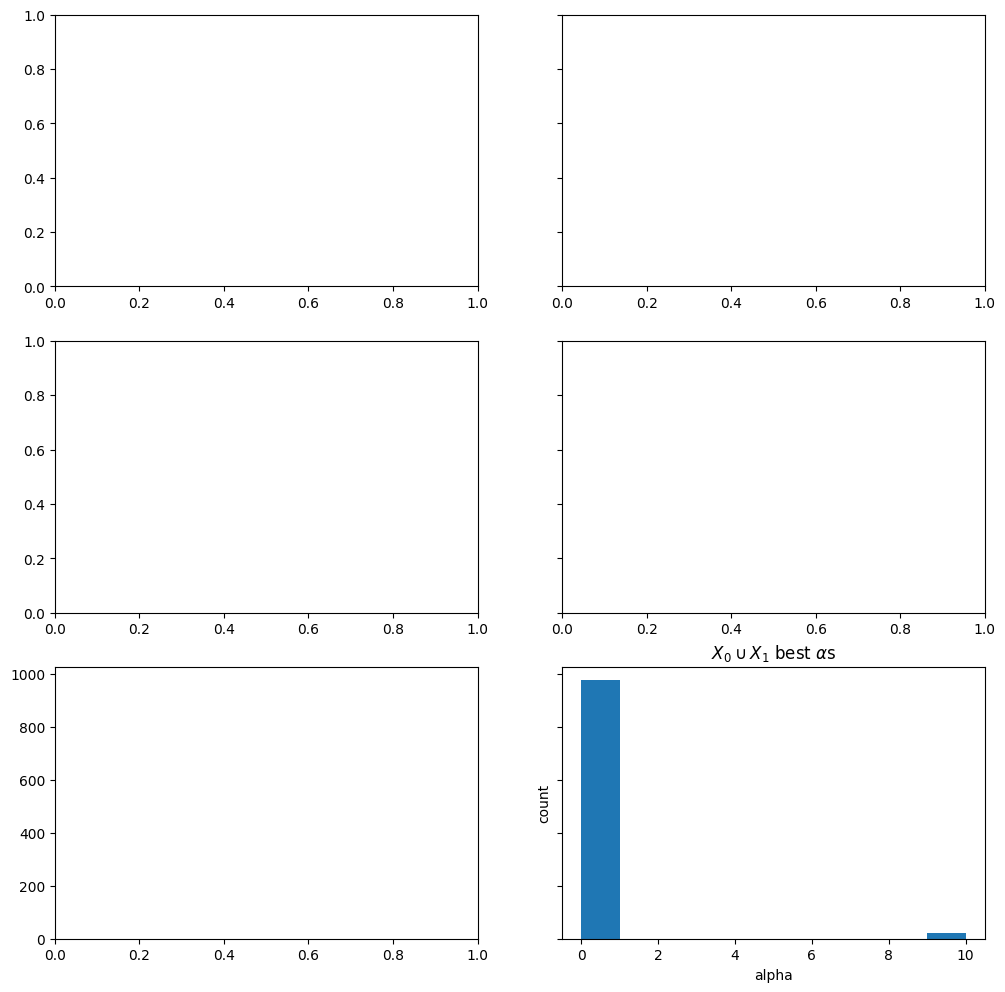

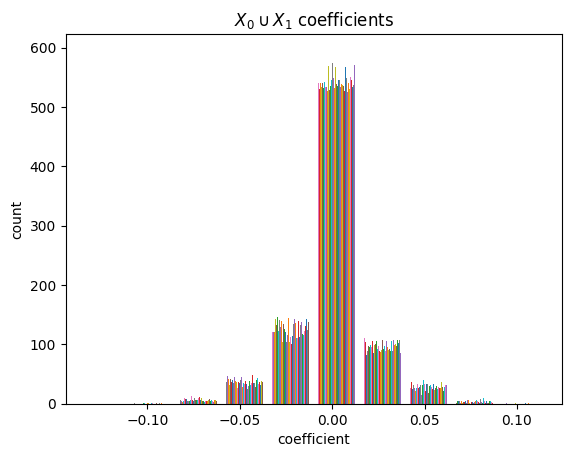

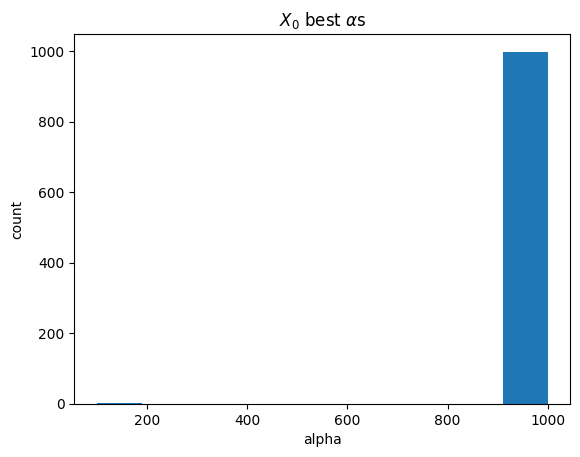

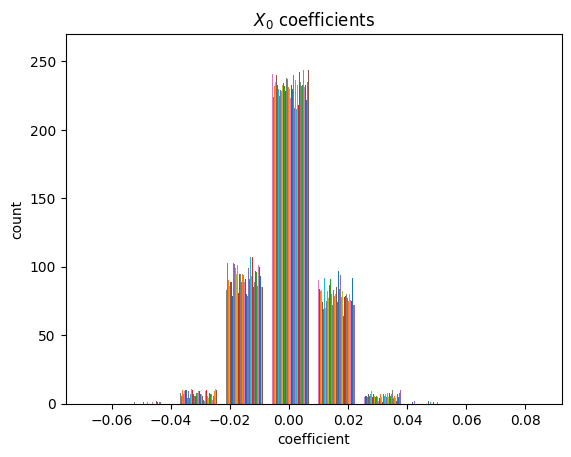

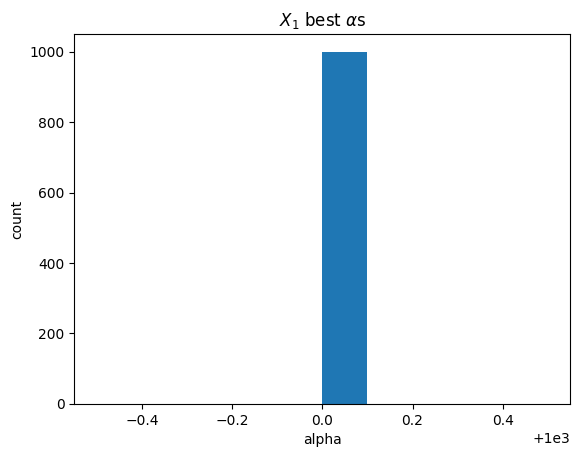

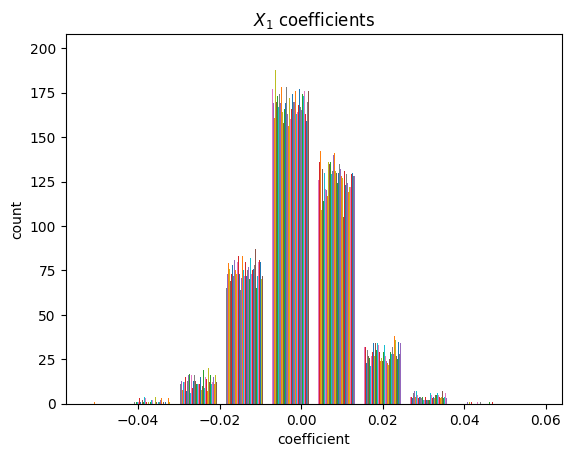

04:55:48 DEBUG:linear model coefficients: [[ 5.1580824e-02 -1.1420473e-02  1.7347753e-02 ... -2.4940428e-08
  -5.6519354e-09 -2.7233162e-08]
 [-1.1420450e-02  4.7300220e-02  1.6183782e-02 ...  7.3553828e-08
  -1.0066001e-08  3.0208248e-08]
 [ 1.7347755e-02  1.6183805e-02  4.5761630e-02 ... -7.4417805e-09
   8.0523344e-10 -9.2445855e-09]
 ...
 [ 7.1878153e-10 -1.1517476e-09 -1.8165891e-10 ... -1.1250432e-09
  -2.8160478e-08  1.6056969e-08]
 [ 8.7382650e-11  1.1583593e-09  6.7910788e-11 ...  1.5773105e-08
   1.3541770e-08  1.7996859e-08]
 [-6.6441609e-11 -2.8755043e-10  1.5020873e-10 ... -7.7354816e-09
  -8.5624197e-10 -8.8370768e-09]]
04:55:48 DEBUG:linear model coefficients: [[ 5.1580835e-02 -1.1420488e-02  1.7347742e-02 ...  5.5566046e-10
  -6.5277335e-09 -6.5254424e-10]
 [-1.1420461e-02  4.7300216e-02  1.6183794e-02 ...  9.0188945e-10
  -6.4906924e-09  1.0606352e-08]
 [ 1.7347744e-02  1.6183812e-02  4.5761600e-02 ... -3.9902863e-09
  -8.3239211e-09 -2.6386857e-09]
 ...
 [ 3.1956213e-

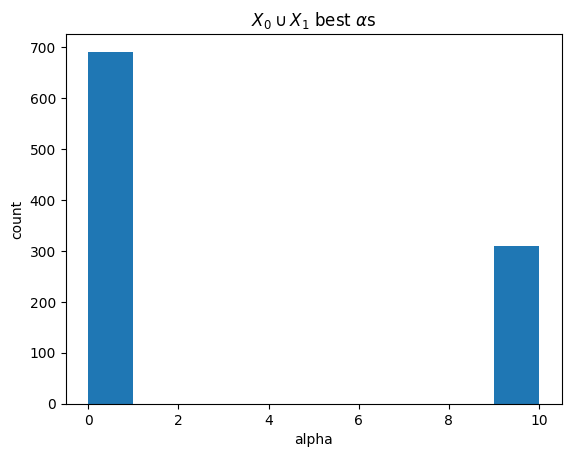

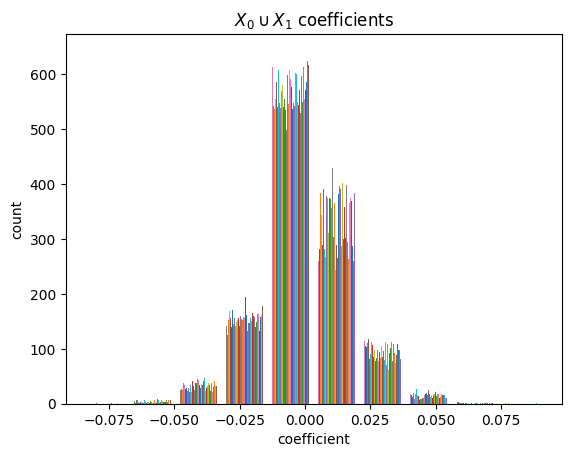

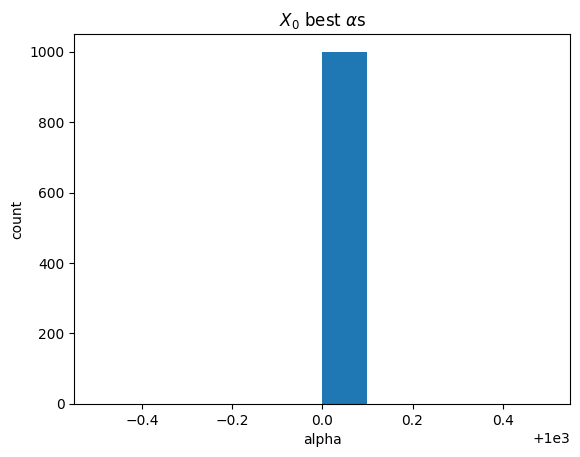

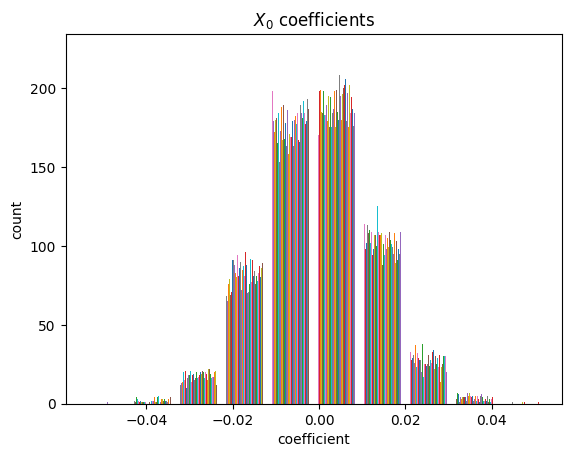

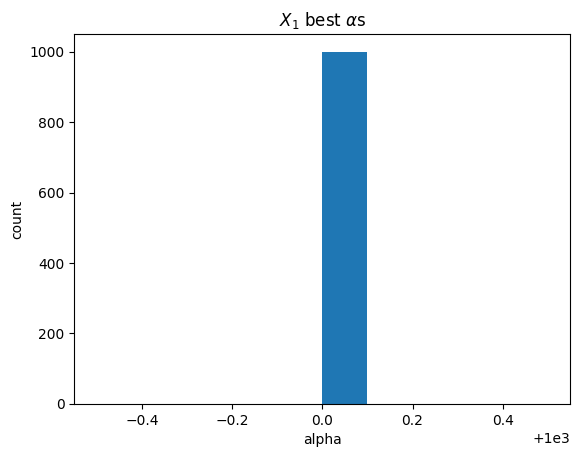

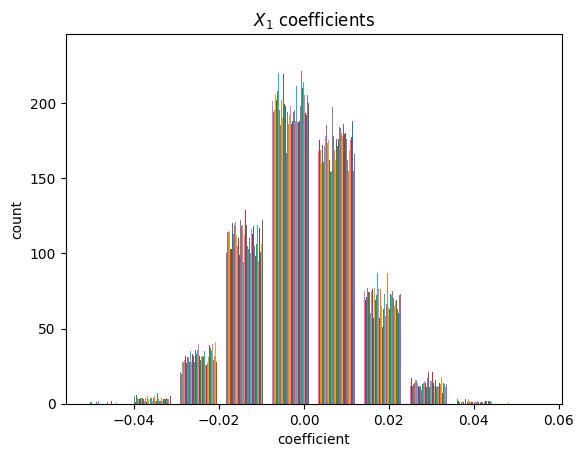

04:56:17 DEBUG:linear model coefficients: [[ 3.2439956e-01  1.0443866e-02 -2.4731174e-02 ...  1.2870076e-09
  -4.7793014e-09 -9.1196988e-09]
 [ 1.0443758e-02  3.4680983e-01  3.6131591e-05 ... -2.0954758e-09
  -3.0966476e-08  1.3969839e-08]
 [-2.4731223e-02  3.6202371e-05  3.3872053e-01 ... -9.3132257e-09
   5.5879354e-09 -3.1664968e-08]
 ...
 [ 4.5134052e-09  6.9276229e-09 -1.1675331e-08 ... -1.9865647e-09
  -1.1731374e-08 -1.9560693e-08]
 [-2.9440488e-11  6.0938707e-09 -3.9500607e-09 ... -3.4891454e-09
  -8.2712868e-09 -8.1084801e-09]
 [ 6.8141168e-09  7.2885200e-09  2.3279474e-09 ... -3.0790117e-09
  -6.7631536e-09  3.8023709e-09]]
04:56:19 DEBUG:linear model coefficients: [[ 3.2439950e-01  1.0443747e-02 -2.4731249e-02 ...  1.5788521e-08
   2.0857582e-09  8.7944887e-09]
 [ 1.0443663e-02  3.4680977e-01  3.6168844e-05 ... -3.6743586e-09
   3.3032848e-09  3.6379788e-10]
 [-2.4731318e-02  3.6112964e-05  3.3872059e-01 ... -8.7311491e-10
  -3.5855919e-08 -1.0652002e-08]
 ...
 [-2.5986346e-

AssertionError: Number of samples must be greater than the sum of ranks.

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharey='row')

for i, shared_dimension in enumerate([10, 100, 1000]):
    dimensions = feature_space_dimensions.copy()
    dimensions[0] = shared_dimension

    _n_samples_train = 2 * sum(dimensions)

    (Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(dimensions, scalars, n_targets, _n_samples_train,
                                                            n_samples_test, noise_scalar)
    (score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test, Y_train,
                                                                                          Y_test, cv=cv)
    vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, dimensions, scalars, n_targets,
                _n_samples_train, n_samples_test, noise_scalar, ax=axs[i, 0], fig=fig)
    axs[i, 0].set_title(f"Variance Partitioning (Shared Dim: {shared_dimension})")

    (full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0,
     residual_scores_1) = residual_method(
        Xs_train, Xs_test, Y_train, Y_test, use_ols=True, return_full_variance=True, cv=cv)

    rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1,
                dimensions, scalars, n_targets, _n_samples_train, n_samples_test, noise_scalar, ax=axs[i, 1], fig=fig)
    axs[i, 1].set_title(f"Residual Method (Shared Dim: {shared_dimension})")

plt.tight_layout()
plt.show()

# Scalars

In [ ]:
# Updated code to put each plot into the subplot axes, with scalars along the rows and vp and rm in the columns
n_scalars = 5
fig, axs = plt.subplots(n_scalars, 2, figsize=(12, n_scalars * 4), sharey='row')  # Adjust figure size dynamically

for i, shared_scalar in enumerate(np.linspace(0, 1, n_scalars)):
    _scalars = [shared_scalar, (1 - shared_scalar) / 2, (1 - shared_scalar) / 2]
    (Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(feature_space_dimensions, _scalars, n_targets,
                                                            n_samples_train, n_samples_test, noise_scalar)
    (score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test, Y_train,
                                                                                          Y_test, cv=cv,
                                                                                          score_func=himalaya.scoring.r2_score)
    # Variance Partitioning subplot
    vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, _scalars,
                n_targets, n_samples_train, n_samples_test, noise_scalar, ax=axs[i, 0], fig=fig)
    axs[i, 0].set_title(f"Variance Partitioning (Shared scalar: {shared_scalar:.2f})")

    # Residual Method subplot
    full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1 = residual_method(
        Xs_train, Xs_test, Y_train, Y_test, use_ols=True, return_full_variance=True, cv=cv,
        score_func=himalaya.scoring.r2_score)

    rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1,
                feature_space_dimensions, _scalars, n_targets, n_samples_train, n_samples_test, noise_scalar,
                ax=axs[i, 1], fig=fig)
    axs[i, 1].set_title(f"Residual Method (Shared scalar: {shared_scalar:.2f})")

plt.tight_layout()  # To avoid overlap of subplots
plt.show()